In [11]:
import numpy as np
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import ipywidgets as widgets

import random
import math

import itertools

import matplotlib.gridspec as gridspec

import urllib
import string
import urllib.parse
import urllib.request
import string
from distutils.dir_util import mkpath

import finam_parser
from finam_parser.classes import *
import finam_parser.http_queries as queries
import finam_parser.import_stocks as import_stocks

from pandas_getter.file_reader import *
import pandas_getter.file_reader as fr
from abc import ABC, abstractmethod
#--------------------------------------------------------------------------------------------------------v
#  Markets:
#   MosBirzha = 1
#   MosBirzha top = 200
#   ? = 8
#   Bonds = 2
#   Indexes = 6
#   Currencies = 45
#   US(BATS) = 25, 517
#   bad markets = 91, 519
#
#  'emitents' = [(ticker, market, frame)]

# set of portfolios to iterate through looks like:

experiment_number = '0'

market = '1'
sample_number = 2
portfolio_size = 2
data_folder = ('./')
download_path = data_folder + 'DATA/'
mkpath(download_path)

print('Files will be in ' + download_path)

emitent_list = queries.define_market_emitents(market)[1]

#SimpleQuery objects
portfolios = [
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.min1, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.min5, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.min10, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.min15, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.min30, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2023', '14.02.2023', Period.hour, download_path), 
    SimpleQuery('1', 'NLMK', '13.02.2022', '13.02.2023', Period.day, download_path), 
    SimpleQuery('1', 'GAZP', '13.02.2022', '13.02.2023', Period.week, download_path),
    SimpleQuery('1', 'TCSG', '13.02.2022', '13.02.2023', Period.month, download_path),
]

print(f'Exporting data to files({len(portfolios)})...')
for p in portfolios:
    import_stocks.import_to_file(p)
print('Complete')


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
class ShapeType(IntEnum):
    Candle, Line = range(2)
class LineType(IntEnum):
    Open, Close, High, Low = fr.COL_NAMES.open, fr.COL_NAMES.close, fr.COL_NAMES.high, fr.COL_NAMES.low

class Shape(ABC):

    @abstractmethod
    def draw(self, frame: pd.DataFrame):
        pass
    
    @property
    @abstractmethod
    def get_shape_type(self) -> ShapeType:
        pass 
class Candle(Shape):
    def __init__(self, width_candle: int = 0.95, width_min_max: int = 0.3, 
                 color_up: str = 'green', color_down: str = 'red') -> None:
        self.width_candle = width_candle
        self.width_min_max = width_min_max
        self.color_up  = color_up
        self.color_down = color_down
    @property
    def get_shape_type(self) -> ShapeType:
        return ShapeType.Candle

    def draw(self, prices: pd.DataFrame):
        #only draws a line, no clue about scaling, titles and axes stuff...
        col1 = self.color_up
        col2 = self.color_down

        up = prices[prices[fr.COL_NAMES.close] >= prices[fr.COL_NAMES.open]]
        down = prices[prices[fr.COL_NAMES.close] < prices[fr.COL_NAMES.open]]
        #plot up prices
        plt.bar (up[fr.COL_NAMES.date_iso], up[fr.COL_NAMES.close] - up[fr.COL_NAMES.open], self.width_candle, bottom=up[fr.COL_NAMES.open], color=col1)
        plt.bar (up[fr.COL_NAMES.date_iso], up[fr.COL_NAMES.high] - up[fr.COL_NAMES.close], self.width_min_max, bottom=up[fr.COL_NAMES.close], color=col1)
        plt.bar (up[fr.COL_NAMES.date_iso], up[fr.COL_NAMES.low] - up[fr.COL_NAMES.open], self.width_min_max, bottom=up[fr.COL_NAMES.open], color=col1)

        #plot down prices
        plt.bar (up[fr.COL_NAMES.date_iso], down[fr.COL_NAMES.close] - down[fr.COL_NAMES.open], self.width_candle, bottom=down[fr.COL_NAMES.open], color=col2)
        plt.bar (up[fr.COL_NAMES.date_iso], down[fr.COL_NAMES.high] - down[fr.COL_NAMES.open], self.width_min_max, bottom=down[fr.COL_NAMES.open], color=col2)
        plt.bar (up[fr.COL_NAMES.date_iso], down[fr.COL_NAMES.low] - down[fr.COL_NAMES.close], self.width_min_max, bottom=down[fr.COL_NAMES.close], color=col2)


class Line(Shape):
    def __init__(self, format: str = '-', color: str = 'black', 
                 linewidth: int = 1, frame_export_type: LineType = LineType.Close):
        self.format = format
        self.color = color
        self.linewidth = linewidth
        self.frame_export_type = frame_export_type
    
    @property
    def get_shape_type(self) -> ShapeType:
        return ShapeType.Line
    
    @property
    def draw(self, prices: pd.DataFrame):
        plt.plot(prices[fr.COL_NAMES.date_iso], prices[self.frame_export_type], 
                 self.format, linewidth=self.linewidth, color=self.color)


prices_main = fr.get_dataframe('./DATA/' + portfolios[1].file_format() + '.txt')
shape_candle = Candle()
shape_candle.draw(prices_main)

shape_line = Line()
shape_line.draw(prices_main)

plt.show()
# width_candle = 0.95
# width_min_max = 0.3
# #define up and down prices


# #define colors to use
# col1 = 'green'
# col2 = 'red'

# #rotate x-axis tick labels
# plt.xticks (rotation= 45 , ha='right')

# prices['EWMA30'] = prices['close'].ewm(span=30).mean()
# prices['EWMA30'].plot()
# my_dpi = 96
# plt.figure(figsize=(800/my_dpi * 10, 800/my_dpi * 10), dpi=my_dpi)


#display candlestick chart
# fg = plt.figure(figsize=(9, 9), constrained_layout=True)
# gs = fg.add_gridspec(5, 5)
# fig_ax_1 = fg.add_subplot(gs[0, :3])
# fig_ax_1.set_title('gs[0, :3]')
# fig_ax_2 = fg.add_subplot(gs[0, 3:])
# fig_ax_2.set_title('gs[0, 3:]')
# fig_ax_3 = fg.add_subplot(gs[1:, 0])
# fig_ax_3.set_title('gs[1:, 0]')
# 42
# fig_ax_4 = fg.add_subplot(gs[1:, 1])
# fig_ax_4.set_title('gs[1:, 1]')
# fig_ax_5 = fg.add_subplot(gs[1, 2:])
# fig_ax_5.set_title('gs[1, 2:]')
# fig_ax_6 = fg.add_subplot(gs[2:4, 2])
# fig_ax_6.set_title('gs[2:4, 2]')
# fig_ax_7 = fg.add_subplot(gs[2:4, 3:])
# fig_ax_7.set_title('gs[2:4, 3:]')
# fig_ax_8 = fg.add_subplot(gs[4, 3:])
# fig_ax_8.set_title('gs[4, 3:]')



Files will be in ./DATA/
Exporting data to files(9)...


IndexError: list index out of range

In [ ]:
import numpy as np
import scipy as sp
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
import ipywidgets as widgets

import random
import math

import itertools

import matplotlib.gridspec as gridspec

import urllib
import string
import urllib.parse
import urllib.request
import string
from distutils.dir_util import mkpath

import finam_parser
from finam_parser.classes import *
import finam_parser.http_queries as queries
import finam_parser.import as import

from pandas_getter import file_reader
from enum import StrEnum

market = '1'
data_folder = ('./')
download_path = data_folder + 'DATA/'
mkpath(download_path)

print('Files will be in ' + download_path)

emitent_list = queries.define_market_emitents(market)[1]

#SimpleQuery objects
portfolios = [
    SimpleQuery('1', 'NLMK', '13.02.2022', '13.02.2023', Period.hour, download_path), 
    SimpleQuery('1', 'GAZP', '13.02.2022', '13.02.2023', Period.day, download_path)
]


class COL_NAMES(StrEnum):
    ticker = 'ticker', 
    per = 'per', 
    date = 'date', 
    time = 'time', 
    open = 'open', 
    high = 'high', 
    low = 'low',
    close = 'close', 
    vol = 'vol',
    date_iso = 'date_iso'

COLUMNS = [COL_NAMES.ticker, COL_NAMES.per, COL_NAMES.date, COL_NAMES.time, 
    COL_NAMES.open, COL_NAMES.high, COL_NAMES.low, COL_NAMES.close, COL_NAMES.vol, COL_NAMES.date_iso]


print(f'Exporting data to files({len(portfolios)})...')
for p in portfolios:
    import.import_to_file(p)
print('Complete')

print(portfolios[0].file_format())
prices_main = file_reader.get_dataframe('./DATA/' + portfolios[0].file_format() + '.txt')
print(prices_main.head())





Files will be in ./DATA/
Exporting data to files(2)...
Loaded:  ./DATA/stocks_NLMK_13022022_13022023.txt
Loaded:  ./DATA/stocks_GAZP_13022022_13022023.txt
Complete
stocks_NLMK_13022022_13022023
  <TICKER>  <PER>  <DATE>  <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>    <VOL>
0     NLMK     60  140222     800  220.80  220.80  216.54   219.76  1104770
1     NLMK     60  140222     900  219.60  223.80  219.28   222.90   526170
2     NLMK     60  140222    1000  222.96  223.50  220.30   221.46   512050
3     NLMK     60  140222    1100  221.10  226.00  220.92   224.56  1413990
4     NLMK     60  140222    1200  224.60  225.42  223.78   223.98  1192890


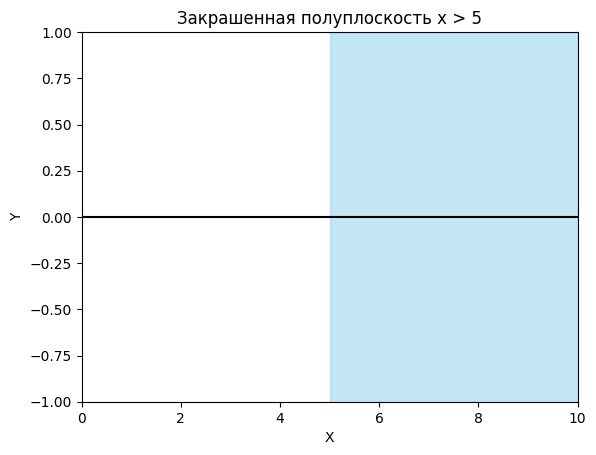

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Границы области графика
x = np.linspace(0, 10, 100)
y = np.linspace(-1, 1, 100)

# Создаем координаты для полуплоскости x > 5
x_polygon = [5, 10, 10, 5]
y_polygon = [-1, -1, 1, 1]

# Создаем график
plt.plot(x, np.zeros_like(x), color='black')  # Горизонтальная прямая на уровне y=0
plt.fill(x_polygon, y_polygon, color='skyblue', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Закрашенная полуплоскость x > 5')

plt.xlim(0, 10)
plt.ylim(-1, 1)

plt.show()